# How data turned me into a millionaire

After a long time, I downloaded and installed World of Warcraft again. Probably influenced by my current job position, I approached it with much more focus on economics and have soon set the goal to reach 1 Million gold.

To put things into perspective, in-game gold can be converted into real money and, at the time of this post, one million gold is enough to pay for 6 months of WoW's subscription cost.

Initially I tried to earn gold by simply relying on my intuition and (outdated) knowledge of the game. However, the development of my liquid gold was not that promising and I could not even reach a third of my goal.
Tired of poor results, I transitioned to a more analytical approach and decided to gather data that could support my decisions. As you can see from the chart below, I soon started to increase my available capital and finally reached the desired one million mark.

<img src="1mil.png">

# Data collection

In this notebook we will replicate my results by reading the same data that I have used. If you want to use up-to-date data that reflect your server, please use TradeSkillMaster's API by uncommenting the relevant block code.

In [2]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
# Option 2: read from csv
df = pd.read_csv("data_2018-09-26.csv")
df.head(2)

,Unnamed: 0,Class,HistoricalPrice,Id,Level,MarketValue,MinBuyout,Name,NumAuctions,Quantity,...,RegionHistoricalPrice,RegionMarketAvg,RegionMinBuyoutAvg,RegionQuantity,RegionSaleAvg,RegionSaleRate,SubClass,VendorBuy,VendorSell,RegionQuantity_Log
0,0,Consumable,206000,4358,10,0,0,Rough Dynamite,0,0,...,99335,329496,2110734,29,0,0.0,Explosives and Devices,120,30,3.367296
1,1,Consumable,70375,4360,14,109500,0,Rough Copper Bomb,0,0,...,163610,223668,290483,17,0,0.0,Explosives and Devices,240,60,2.833213


In [3]:
#'''
#Documentation: 
#http://support.tradeskillmaster.com/display/KB/TSM+Public+Web+API
#'''

#region = 'EU' #insert your region
#realm = 'nemesis' #insert your realm
#TSM_KEY = '' #insert your API key. This is available from the TSM website after creating a free account.

#r = requests.get('http://api.tradeskillmaster.com/v1/item/{}/{}?format=json&apiKey={}'.format(region, realm, TSM_KEY))
#df = pd.DataFrame(r.json())
#df.head(10)

In [4]:
list(df)

['Unnamed: 0',
 'Class',
 'HistoricalPrice',
 'Id',
 'Level',
 'MarketValue',
 'MinBuyout',
 'Name',
 'NumAuctions',
 'Quantity',
 'RegionAvgDailySold',
 'RegionHistoricalPrice',
 'RegionMarketAvg',
 'RegionMinBuyoutAvg',
 'RegionQuantity',
 'RegionSaleAvg',
 'RegionSaleRate',
 'SubClass',
 'VendorBuy',
 'VendorSell',
 'RegionQuantity_Log']

Most of the names returned by the TSM API are quite intuitive once we understand the following nomenclature.
- Global: this includes data from every active WoW server.
- Region: data for a specific region, i.e. NA or EU.
- Market: every region has a multitude of "realms". A realm auction house (or group of realms if they have low population) is what defines a market.


For example, the difference between _Quantity_ and _RegionQuantity_ is that the first case only counts items in Nemesis (the realm I have selected), whereas the second one includes all the listings in Europe. 
Notice that _NumAuctions_ sometimes differs from _Quantity_ because each auction can include multiple stacks of the same item. E.g. 10x Linen Cloth can all be sold in one single auction, or posted as smaller stacks over multiple auctions.

Some rows that are not interesting and/or usable. In this case we remove items that are not currently present in the action house (i.e. _RegionQuantity_ = 0). Moreover, we remove items with a sale rate of 1 because unrealistic.

In [5]:
#Remove data errors / outliers
df_clean = df[(df["RegionQuantity"] > 0) & (df["RegionSaleRate"] < 1)]
print('Before clean-up: ', df.shape)
print('After clean-up', df_clean.shape)

Before clean-up:  (17428, 21)
After clean-up (16569, 21)


# Data exploration

First, let us look at the data from a high level. For this purpose we will apply t-SNE algorithm [1].

In [6]:
# Relevant numerical columns
feat_cols = ['Level', 'MarketValue', 'MinBuyout', 'NumAuctions', 'Quantity',
             'RegionAvgDailySold', 'RegionHistoricalPrice', 'RegionMarketAvg', 'RegionMinBuyoutAvg', 'RegionQuantity',
             'RegionSaleAvg', 'RegionSaleRate', 'VendorBuy', 'VendorSell']

In [13]:
#https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

from sklearn.manifold import TSNE

tsne = TSNE(verbose=0, n_iter=300, perplexity=60) 
tsne_results = tsne.fit_transform(df_clean[feat_cols])

df_tsne = df_clean.copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

Let us plot the two t-SNE dimensions and assign a different color based on the _Class_ category. 

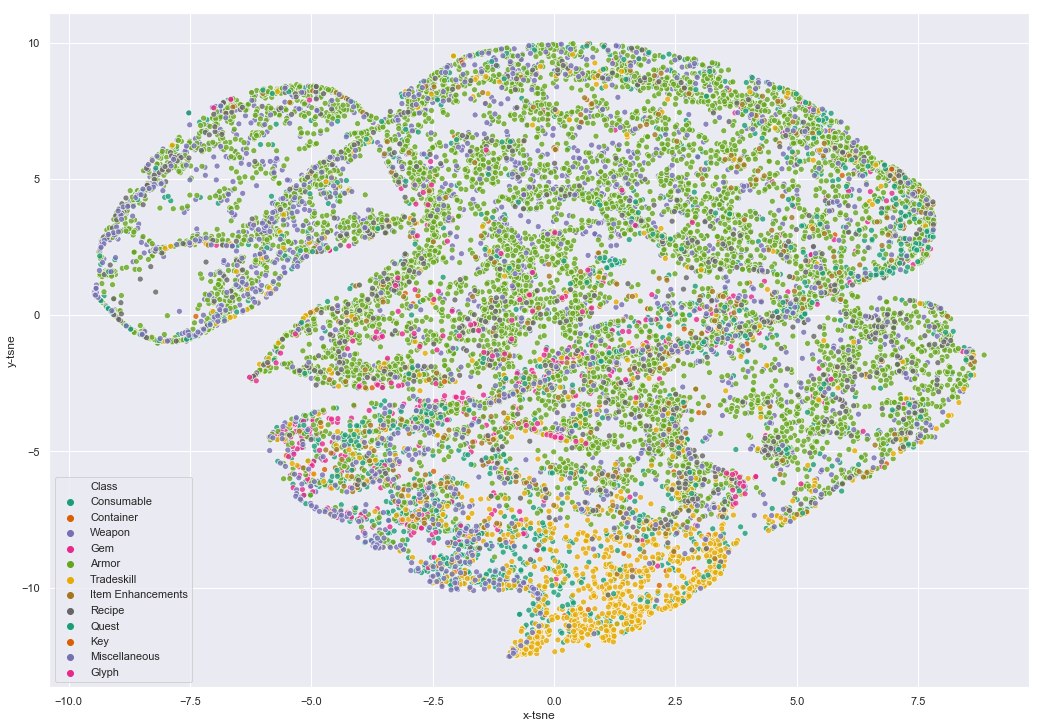

In [15]:
scale = 1.5
X_SIZE = 11.7*scale
Y_SIZE = 8.27*scale

sns.set(rc={'figure.figsize':(X_SIZE,Y_SIZE)})

sns.scatterplot(data=df_tsne, x='x-tsne', y='y-tsne', hue='Class', alpha=.8,
                     palette='Dark2')

Given that we have reduced 14 dimensions into 2 dimensions, t-SNE plots are at times difficult to interpret. Nevertheless, we can still notice that there are patterns categorizing different classes. In particular, the _Tradeskill_ class clearly stands out from all the others.

Next step is to dig further into our dataset and gain some valuable insights about WoW's economics.

Now we group items based on their sale rate and their quantity in the auction house. For a better readibility we will use a log scale for the x-axis (_RegionQuantity_).

[None]

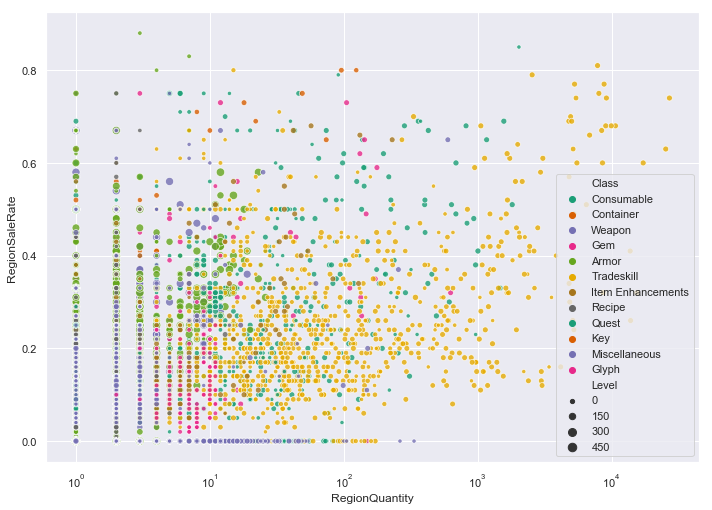

In [16]:
scale = 1.0
X_SIZE = 11.7*scale
Y_SIZE = 8.27*scale

sns.set(rc={'figure.figsize':(X_SIZE,Y_SIZE)})

ax = sns.scatterplot(x="RegionQuantity", y="RegionSaleRate",
                      hue="Class", size=df_clean.Level,
                     alpha=.8,
                     palette='Dark2',
                     #palette='viridis',
                      legend="brief", data=df_clean)
ax.set(xscale="log")

The bottom-left corner covers item that are present in low quantities and have a low sale rate. This does not always mean that they are less valuable. A real-life example of such case could be a Ferrari, since they are rare and not "traded" very often. Still, they are definitely worth a lot of money.

In WoW there are two main categories of items that fit this quarter of the graph: junk and transmog/rare items. We name junk all these items that can easily be bought from a NPC (non-player character) vendor, which scammers try to dump on inexperienced players by tricking them into thinking that these are unobtainable valuable items. Without going too much into details, the second category are items mainly bought by collectors, who are often willing to pay a high price, but who only cover a small part of the World of Warcraft population.

How do we choose a cutoff for the minimum _RegionQuantity_ to remove the majority of value-inefficient items? A simple approach would be to arbitrarily choose a value based on the chart above. Yet, it also seems appropriate to pick different value based on the item class.

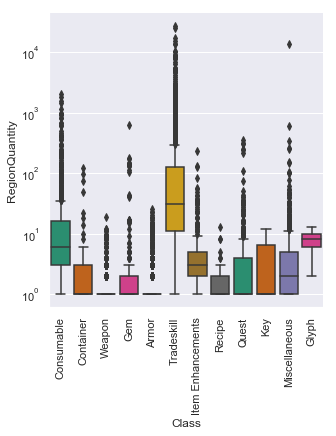

In [17]:
scale_x = 5
scale_y = 1
X_SIZE = 11.7*scale_x
Y_SIZE = 8.27*scale_y

sns.set(rc={'figure.figsize':(X_SIZE,Y_SIZE)})


g = sns.catplot(x="Class", y="RegionQuantity", kind="box", data=df_clean, palette="Dark2");
g.set_xticklabels(rotation=90)
g.set(yscale="log")

As expected, each class has different quantities posted at the auction house. The graph above gives a clear picture, but before deciding on our _RegionQuantity_ cutoff, let us go through one more step and figure out if any of the classes can be completely discarded.

We introduce a new variable _Worth_, measured as: $RegionSaleAvg * RegionQuantity$. This should given another indication of the items that are sold for a good price, but also "often enough".

In [18]:
df_clean['Worth'] = df_clean['RegionSaleAvg'] * df_clean['RegionQuantity']

E:\Users\Megaport\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


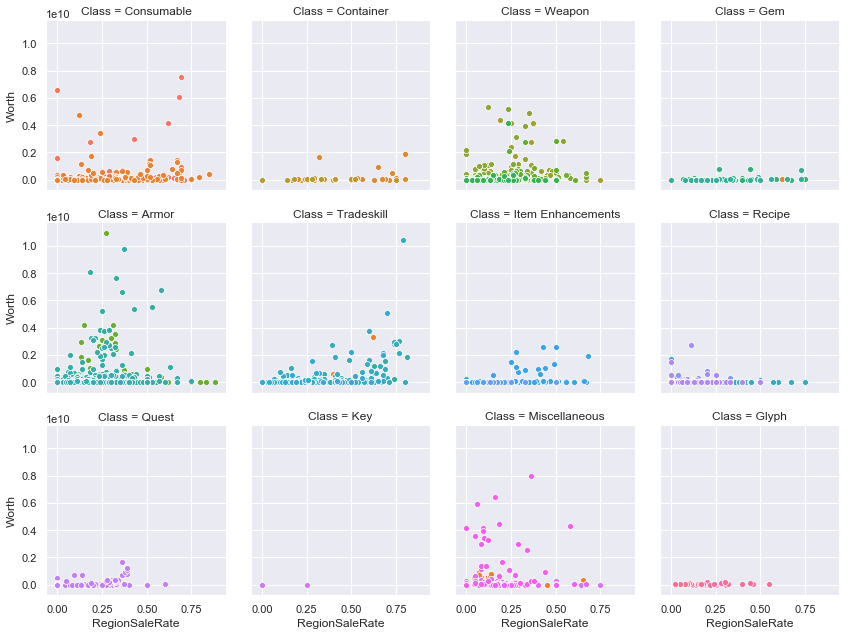

In [19]:
scale = 1.5
X_SIZE = 11.7*scale
Y_SIZE = 8.27*scale

sns.set(rc={'figure.figsize':(X_SIZE,Y_SIZE)})

g = sns.FacetGrid(data=df_clean, col="Class",
                  col_wrap=4, hue="SubClass")
g.map(sns.scatterplot, "RegionSaleRate", "Worth", legend="brief")

_Keys_ are definitely not interesting for our gold making goal. _Gems_, _Glyphs_ and _Quests_ can be profitable but we will only start considering them after we have set up a steady business in the other categories, which appear to be better (at least based on our simple metrics).

Finally, we can considerably reduce our dataset by removing the unwanted classes and by setting the following _RegionQuantiy_ threshold:
- Containers, Weapons, Armors, Item Enhancements, Miscellaneous, Recipes: 5
- Consumables: 10
- Tradeskills: 75

In [20]:
#Consider replacing this block with a function that instead filters out everything below the k-th RegionQuantity percentile  (by Class)
list_low = ['Container','Weapon','Armor','Item Enhancements', 'Miscellaneous', 'Recipe']
list_mid = ['Consumable']
list_high = ['Tradeskill']

df_clean = df_clean[((df_clean['Class'].isin(list_low)) & (df_clean['RegionQuantity'] >= 5)) |
                    ((df_clean['Class'].isin(list_mid)) & (df_clean['RegionQuantity'] >= 10)) |
                    ((df_clean['Class'].isin(list_high)) & (df_clean['RegionQuantity'] >= 75))]

In [21]:
print('Size of new dataset: ', df_clean.size)
print('Number of remaining items per category: ')
df_clean['Class'].value_counts()

Size of new dataset:  32384
Number of remaining items per category: 


Consumable           572
Tradeskill           381
Miscellaneous        226
Armor                130
Item Enhancements    109
Weapon                39
Container             11
Recipe                 4
Name: Class, dtype: int64

At this point one could argue that we have a reasonable dataset size and that we could start looking into the single items. 

After quickly scanning through the item names, we see that the presence for some of these is questionable. For example, [Weak Flux] has still not been filtered out since it shows an ok _MarketValue_ and a reasonable _RegionQuantity_. This is a clear case of scammers trying to speculate on items that do not have any intrinsic value. [Weak Flux] can be bought from NPCs located at convenient locations, and for a very low price. Still, scammers frequently post such items at a very high price to skew the market value. 

How do we protect ourselves from these cheap shots? Our solution is to introduce $R1 = MarketValue / RegionMarketAvg$. 
This value shows how different is the average market price of an item in our server, compared to the average price across Europe. Small differences are normal and should be expected, but they should not be as extreme as the 11.7 R1 value for [Weak Flux]. For these reasons, we will remove everything with a local price 75% higher than the regional value, i.e. R1 > 1.75.

In [22]:
df_clean['R1'] = df_clean['MarketValue'] / df_clean['RegionMarketAvg']

E:\Users\Megaport\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
df_clean[df_clean['Id'] == 2880].R1

13931    11.708622
Name: R1, dtype: float64

In [24]:
df_clean = df_clean[df_clean['R1'] <= 1.75]
print('Size of new dataset: ', df_clean.size)

Size of new dataset:  27669


On a lighter note: crafted Linen Shirts are more expensive in the Italian server compared to the European average. This is probably explained by the strong Italian fashion culture, rather than a higher presence of scammers in this market sector.

In [25]:
df_LS = df[df['Name'].str.contains('Linen Shirt')]
df_LS['R1'] = df_LS['MarketValue'] / df_LS['RegionMarketAvg']
pd.DataFrame.mean(df_LS.R1)

E:\Users\Megaport\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


3.4070546175433356

# Results

Finally, we take all the items within the top k% _Worth_ **per category** (diversification is key) and this will be our final portfolio to invest on!

How do we make money from this list? The long explanation is for another post, but a very simple approach is to buy these items every time that they are posted below 85% their market value, and then repost them at full price.

In [27]:
k = 0.05 # k=5

def quantile_function(df, threshold, col_name):
    qnt = df.quantile(threshold)[col_name]
    return df[df[col_name] >= qnt]

df_clean.groupby('Class').apply(quantile_function, 1-k, 'Worth').Name

Class                   
Armor              5215                 Darkmoon Deck: Fathoms
                   9472           Antiseptic Specimen Handlers
                   11233           Iron-Grip Specimen Handlers
                   12668                  Crushproof Vambraces
                   12669     Fluid-Resistant Specimen Handlers
Consumable         248                  Coastal Healing Potion
                   386                   Flask of the Currents
                   387                Flask of Endless Fathoms
                   388               Flask of the Vast Horizon
                   389                   Flask of the Undertow
                   960                     Swamp Fish 'n Chips
                   969                          Galley Banquet
                   970               Bountiful Captain's Feast
                   1279                      Goblin Glider Kit
                   1331               Elixir of the Rapid Mind
                   1333       

# References

[1] t-SNE algorithm: https://lvdmaaten.github.io/tsne/